# Formalia:

Please read the [assignment overview page](https://github.com/SocialComplexityLab/socialgraphs2021/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday October the 31st, 2021 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via http://peergrade.io/


(If you haven't set up an account on peergrade yet, go to www.peergrade.io/join and type in the class code: ***DPZEV6***.)

### Overview

This year's Assignment 2 is all about analyzing the network of rappers.

Note that this time I'm doing the exercises slightly differently in order to clean things up a bit. The issue is that the weekly lectures/exercises include quite a few instructions and intermediate results that are not quite something you guys can meaningfully answer. 

Therefore, in the assignment below, I have tried to reformulate the questions from the weekly exercises into something that is (hopefully) easier to answer. *Then I also note which lectures each question comes from*; that way, you can easily go back and find additional tips & tricks on how to solve things 😇


----

# Part 0: Building the network 

To create our network, we downloaded the rapper Wiki pages from each coast (during Week 4) and linked them via the hyperlinks connecting pages to each other. To achieve this goal we have used regular expressions.

> * Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the rapper pages with the Wikipedia API.
> * Show the regular expressions you have built and explain in details how they work.

In [16]:
import pandas as pd
import networkx as nx
import os
import requests
import re
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
import nltk
import requests
import community

from nltk.corpus import PlaintextCorpusReader
from nltk import word_tokenize
from nltk import FreqDist
from wordcloud import WordCloud, STOPWORDS

In [3]:
if os.path.exists("files/rappers_undirected.gexf") and os.path.exists("files/rappers_west.gexf") and os.path.exists("files/rappers_east.gexf"):
    df = pd.read_csv("files/rappers.csv")
    di_G = nx.read_gexf("files/rappers_giant_component.gexf")
    di_G_west = nx.read_gexf("files/rappers_west.gexf")
    di_G_east = nx.read_gexf("files/rappers_east.gexf")
    G = di_G.to_undirected()
    G_west = di_G_west.to_undirected()
    G_east = di_G_east.to_undirected()
    print("Graph loaded from file")
else:
    df = pd.read_csv("files/rappers.csv")
    df_west = pd.read_csv("files/WestCoastRappers.csv",index_col=0)
    df_east = pd.read_csv("files/EastCoastRappers.csv",index_col=0)

    df_west['Coast'] = 'West'
    df_east['Coast'] = 'East'

    df = pd.concat([df_west, df_east], ignore_index=True)

    di_G = nx.DiGraph()

    for i in df.index:
        di_G.add_node(df['WikipediaPageName'][i], coast=df['Coast'][i])
    
    baseurl = "https://en.wikipedia.org/w/api.php?"

    pattern = r'\[{2}(.+?)\]{2}'
    word_pattern = r'\b\w+\b'

    for i, rapper in enumerate(df['WikipediaPageName']):
        print(i, rapper)

        params = {
            "action": "query",
            "prop": "revisions",
            "rvprop": "content",
            "format": "json",
            "titles": rapper
        }
        wikitext = requests.get(baseurl, params=params)
        wikijson = wikitext.json()
        key = wikijson['query']['pages'].keys()
        text = wikijson['query']['pages'][str(list(key)[0])]['revisions'][0]['*']
        
        match = re.findall(pattern, text)

        for string in match:
            wikilink = string.split('|')[0]
            if (wikilink in df['WikipediaPageName'].values):
                di_G.add_edge(rapper, wikilink)
    
    di_G_connected = list(di_G.subgraph(c) for c in nx.weakly_connected_components(di_G))
    di_G_giant = di_G_connected[0]
    for subgraph in di_G_connected:
        if len(subgraph) > len(di_G_giant):
            di_G_giant = subgraph
    
    di_G = di_G_giant

    di_G_west = nx.DiGraph()
    for node in di_G.nodes():
        if di_G.nodes[node]['coast'] == 'West':
            di_G_west.add_node(node, coast='West')

    for edge in di_G.edges():
        if di_G.nodes[edge[0]]['coast'] == 'West' and di_G.nodes[edge[1]]['coast'] == 'West':
            di_G_west.add_edge(edge[0], edge[1])

    di_G_east = nx.DiGraph()
    for node in di_G.nodes():
        if di_G.nodes[node]['coast'] == 'East':
            di_G_east.add_node(node, coast='East')

    for edge in di_G.edges():
        if di_G.nodes[edge[0]]['coast'] == 'East' and di_G.nodes[edge[1]]['coast'] == 'East':
            di_G_east.add_edge(edge[0], edge[1])


    nx.write_gexf(di_G, "files/rappers_giant_component.gexf")
    nx.write_gexf(di_G_west, "files/rappers_west.gexf")
    nx.write_gexf(di_G_east, "files/rappers_east.gexf")
        

Graph loaded from file


# Part 1: Network visualization and basic stats

Visualize your network of rappers (from lecture 5) and calculate stats (from lecture 4 and 5). For this exercise, we assume that you have already generated the network and extracted the largest weakly connected component (the "largest weakly connected component" of a directed network is the subgraph consisting of the nodes that would constitute the largest connected component if the network were undirected) . The visualization and statistics should be done for the largest weakly connected component only.

_Exercise 1a_: Stats (see lecture 4 and 5 for more hints)

> * What is the number of nodes in the network? 
> * What is the number of links?
> * Who is the top connected rapper? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?
> * Who are the top 5 most connected east-coast rappers (again in terms of in/out-degree)? 
> * Who are the top 5 most connected west-coast rappers (again in terms of in/out-degree)?
> * Plot the in- and out-degree distributions for the whole network. 
>   * Use axes that make sense for visualizing this particular distribution.
>   * What do you observe? 
>   * Give a pedagogical explaination of why the in-degree distribution is different from the out-degree distribution?
> * Find the exponent (by using the `powerlaw` package) for the in- and out-degree distributions. What does it say about our network?
> * Compare the two degree distributions two the degree distribution of a *random network* (undirected) with the same number of nodes and probability of connection *p*. Comment your results.

_Exercise 1b_: Visualization (see lecture 5 for more hints)

> * Create a nice visualization of the total (directed) network:
>   * Color nodes according to the role;
>   * Scale node-size according to degree;
>   * Get node positions based on either the Force Atlas 2 algorithm, or the built-in algorithms for networkX;
>   * Whatever else you feel like that would make the visualization nicer.
> * Describe the structure you observe. What useful information can you decipher from this?

In [19]:
# 1. What is the number of nodes in the network? 2. 
print(di_G)

DiGraph with 728 nodes and 5809 edges


#### What is the number of nodes in the network? 
>There are 728 nodes in the graph

#### What is the number of links?
>There are 5809 edges in the graph

#### Who is the top connected rapper? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?

In [20]:
most_conected_in = sorted((di_G.in_degree), key=lambda x: x[1], reverse=True)[0]
most_conected_out = sorted((di_G.out_degree), key=lambda x: x[1], reverse=True)[0]
print(most_conected_in)
print(most_conected_out)

('Snoop Dogg', 127)
('Drag-On', 52)


>Snoop Dogg is the most connected rapper with regard to in-degrees. \
>Drag-On is the most connected rapper with regard to out out-degrees.

#### Who are the top 5 most connected east-coast rappers (again in terms of in/out-degree)? 
#### Who are the top 5 most connected west-coast rappers (again in terms of in/out-degree)? 

In [9]:
east_dict = {}
west_dict = {}

for node, attributes in di_G.nodes(data=True):
    if attributes['coast'] == "East":
        east_dict[node] = {
            'in_degree': di_G.in_degree(node),
            'out_degree': di_G.out_degree(node),
            'coast': "East"
        }
    else:
        west_dict[node] = {
            'in_degree': di_G.in_degree(node),
            'out_degree': di_G.out_degree(node),
            'coast': "West"
        }

top5_in_east = dict(sorted(east_dict.items(), key=lambda x: x[1]['in_degree'], reverse=True)[:5])
top5_out_east = dict(sorted(east_dict.items(), key=lambda x: x[1]['out_degree'], reverse=True)[:5])
top5_in_west = dict(sorted(west_dict.items(), key=lambda x: x[1]['in_degree'], reverse=True)[:5])
top5_out_west = dict(sorted(west_dict.items(), key=lambda x: x[1]['out_degree'], reverse=True)[:5])

print(top5_in_east)
print(top5_out_east)
print(top5_in_west)
print(top5_out_west)

{'Jay-Z': {'in_degree': 114, 'out_degree': 30, 'coast': 'East'}, 'Nas': {'in_degree': 98, 'out_degree': 33, 'coast': 'East'}, '50 Cent': {'in_degree': 91, 'out_degree': 29, 'coast': 'East'}, 'Busta Rhymes': {'in_degree': 82, 'out_degree': 25, 'coast': 'East'}, 'The Notorious B.I.G.': {'in_degree': 63, 'out_degree': 26, 'coast': 'East'}}
{'Drag-On': {'in_degree': 6, 'out_degree': 52, 'coast': 'East'}, 'Black Thought': {'in_degree': 20, 'out_degree': 42, 'coast': 'East'}, 'Jahlil Beats': {'in_degree': 9, 'out_degree': 35, 'coast': 'East'}, 'MC Lyte': {'in_degree': 20, 'out_degree': 35, 'coast': 'East'}, 'Uncle Murda': {'in_degree': 10, 'out_degree': 34, 'coast': 'East'}}
{'Snoop Dogg': {'in_degree': 127, 'out_degree': 22, 'coast': 'West'}, 'Dr. Dre': {'in_degree': 81, 'out_degree': 36, 'coast': 'West'}, 'Kendrick Lamar': {'in_degree': 75, 'out_degree': 36, 'coast': 'West'}, 'Tupac Shakur': {'in_degree': 70, 'out_degree': 19, 'coast': 'West'}, 'E-40': {'in_degree': 60, 'out_degree': 16, '

>The top 5 most connected east rappers with regards to in-degrees are:
>   1. Jay-Z
>   2. Nas
>   3. 50 Cent
>   4. Busta Rhymes
>   5. The Notorious B.I.G.

>The top 5 most connected east rappers with regards to out-degrees are:
>   1. Drag-On
>   2. Black Thought
>   3. Jahlil Beats
>   4. MC Lyte
>   5. Uncle Murda

>The top 5 most connected west rappers with regards to in-degrees are:
>   1. Snoop Dogg
>   2. Dr. Dre
>   3. Kendrick Lamar
>   4. Tupac Shakur
>   5. E-40

>The top 5 most connected west rappers with regards to out-degrees are:
>   1. DJ Dahi
>   2. Dr. Dre
>   3. The Game
>   4. Kendrick Lamar
>   5. Kurupt

#### Plot the in- and out-degree distributions for the whole network.

127
0
728


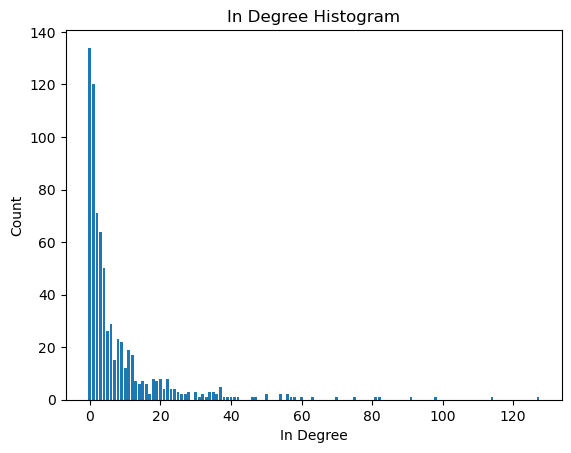

In [12]:
# Plot in and out degree distribution
k_in = [d for n, d in di_G.in_degree()] 
max_k_in = np.max(k_in)
min_k_in = np.min(k_in)
print(max_k_in)
print(min_k_in)
v = np.arange(min_k_in,max_k_in+2)

counts_in, bins_in = np.histogram(k_in, bins=v)
sum_counts_in = np.sum(counts_in)
print(sum_counts_in)

plt.bar(bins_in[:-1], counts_in)

plt.title("In Degree Histogram")
plt.ylabel("Frequency")
plt.xlabel("In Degree")
plt.show()

52
52
728


<function matplotlib.pyplot.show(close=None, block=None)>

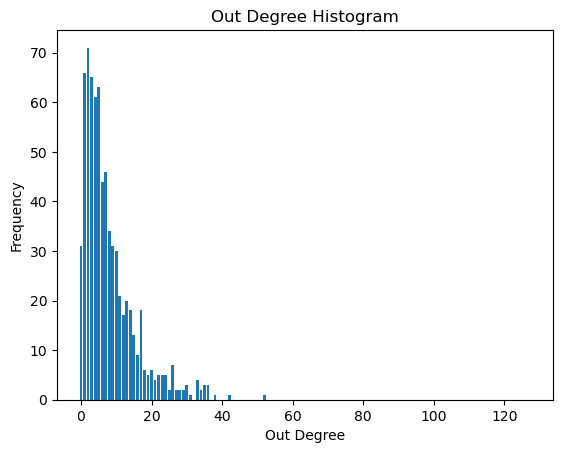

In [21]:
k_out = [d for n, d in di_G.out_degree()]
max_k_out = max(k_out)
min_k_out = min(k_out)
print(max_k_out)
print(max_k_out)
v = np.arange(min_k_in, max_k_in+2)

counts_out, bins_out = np.histogram(k_out, bins=v)
sum_counts_out = np.sum(counts_out)
print(sum_counts_out)

plt.bar(bins_out[:-1], counts_out)
plt.title("Out Degree Histogram")
plt.xlabel("Out Degree")
plt.ylabel("Frequency")
plt.show

#### What do you observe? 

>We see that the in-degrees are very low with the most common being 0, while the out-degrees most common value is a little higher.
>
>The vast majority of in and out degrees are between 0 and 15.
>
>The frequency for both in and out degrees degrees really fast after their peek.
>
>The max for in-degrees is 127 and for out-degrees it is 52.

#### Give a pedagogical explaination of why the in-degree distribution is different from the out-degree distribution?

>The reason why the in- and out-degrees look different is because real networks tend to develop hubs. For the rapper wikipedia pages the hubs might be caused by very influential individuals where these influential individuals will have a lot of in-degrees. The opposite is case for very non-influential individuals who might be new or have a limited career. These individuals are a lot more common which is why there are so many nodes with low or no in-degrees. 
>
>Fame in the rapper world is also easier achieved when you have contacts or were "discovered" by someone who is already influential. Therefore, some of the rappers fame should be attributed to atleast a few other rapper, not every other rapper, which is why there are a lot more rappers with an out-degree of 1 than there are rappers with out-degree 0. It can also be seen that the amount of rappers with a high out degree are more common than rappers with a high in-degree. 
>
>This explains why the max value for in-degrees are 127 and why the max value for out degrees is much lower at 52. But there of course a lot of other factors too, like have active the artist is, how many other artists the rapper has collaborated with, but this is one explanation.

#### Find the exponent (by using the `powerlaw` package) for the in- and out-degree distributions. What does it say about our network?

In [18]:
# Powerlaw
k = k_in + k_out
alpha = powerlaw.Fit(k).alpha
alpha_in = powerlaw.Fit(k_in).alpha
alpha_out = powerlaw.Fit(k_out).alpha

print(f'alpha: {alpha}')
print(f'alpha in: {alpha_in}')
print(f'alpha out: {alpha_out}')

alpha: 3.281594832105964
alpha in: 2.728424664021232
alpha out: 12.242368936892056


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/opt/anaconda3/envs/e1_social_graph/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


# Part 2: Word-clouds

Create your own version of the word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from rappers' Wikipedia pages.

Here's what you need to do:
> * Create a word-cloud for each coast according to the novel TF-TR method. Feel free to make it as fancy as you like. Explain your process and comment on your results.
> * For each coast, what are the 5 words with the highest TR scores? Comment on your result.

In [ ]:
west_file_list = []
east_file_list = []
for i, (rapper, coast) in enumerate(zip(df["WikipediaPageName"],df["Coast"])):
    # save text to file
    file_name = rapper + '.txt'
    file_name = file_name.replace('-', '_')
    file_name = file_name.replace(' ', '_')
    file_name = file_name.replace('?', '')
    if coast == "West":
        west_file_list.append(file_name)
    else:
        east_file_list.append(file_name)

In [ ]:
corpus_root = 'rapper_texts'
west_corpus = PlaintextCorpusReader(corpus_root, west_file_list)

corpus_root = 'rapper_texts'
east_corpus = PlaintextCorpusReader(corpus_root, east_file_list)

west_raw = west_corpus.raw()
east_raw = east_corpus.raw()

stopwords = nltk.corpus.stopwords.words('english')

west_tokens = word_tokenize(west_raw)
west_words = [w.lower() for w in west_tokens if (w.isalpha() and w not in stopwords)]

east_tokens = word_tokenize(east_raw)
east_words = [w.lower() for w in east_tokens if (w.isalpha() and w not in stopwords)]

In [ ]:
fdist_west = FreqDist(west_words)
fdist_east = FreqDist(east_words)

dict_west_w = dict()
dict_east_w = dict()
dict_west_TFTR = dict()
dict_east_TFTR = dict()
c = 1

for w in fdist_west:
    if w in fdist_east:
        dict_west_w[w] = fdist_west[w]/(fdist_east[w]+c)
        dict_east_w[w] = fdist_east[w]/(fdist_west[w]+c)
        dict_east_TFTR[w] = dict_east_w[w]*fdist_east[w]
    else:
        dict_west_w[w] = fdist_west[w]/c
        dict_east_w[w] = 0
        dict_east_TFTR[w] = 0
    dict_west_TFTR[w] = dict_west_w[w]*fdist_west[w]
    
for w in fdist_east:
    if w not in fdist_west:
        dict_west_w[w] = 0
        dict_east_w[w] = fdist_east[w]/c
        dict_west_TFTR[w] = 0
        dict_east_TFTR[w] = dict_east_w[w]*fdist_east[w]

dict_west_TFTR = dict(sorted(dict_west_TFTR.items(), key=lambda x:x[1], reverse=True))
dict_east_TFTR = dict(sorted(dict_east_TFTR.items(), key=lambda x:x[1], reverse=True))
print(dict_west_TFTR)
print(dict_east_TFTR)

{'okonma': 10609.0, 'gomez': 6400.0, 'broadus': 6084.0, 'shinoda': 4418.0, 'tde': 4225.0, 'kgositsile': 4225.0, 'lamar': 3513.130434782609, 'wid': 3362.0, 'lars': 3249.0, 'petulla': 3136.0, 'dre': 3022.9514563106795, 'shwayze': 2601.0, 'the': 2556.5665991587475, 'nichkhun': 2500.0, 'snoop': 2403.5555555555557, 'california': 2375.132530120482, 'marrow': 2304.0, 'suga': 2187.0, 'stevens': 2178.0, 'dogg': 2096.8988764044943, 'kreayshawn': 1936.0, 'album': 1885.161511268228, 'cube': 1774.086956521739, 'yg': 1760.142857142857, 'released': 1734.5844155844156, 'quik': 1600.0, 'medeiros': 1521.0, 'compton': 1487.1176470588236, 'hopsin': 1458.0, 'aminé': 1444.0, 'seales': 1444.0, 'park': 1425.1904761904761, 'keak': 1369.0, 'hicks': 1369.0, 'mosey': 1365.3333333333333, 'eiht': 1323.0, 'angeles': 1308.8898305084747, 'los': 1306.051094890511, 'marv': 1300.5, 'hanley': 1296.0, 'retrievin': 1225.0, 'hussle': 1210.0, 'nerdcore': 1156.0, 'keem': 1156.0, 'aceyalone': 1152.0, 'in': 1109.315593220339, 'm

In [ ]:
west_str = ""
east_str = ""
for w in dict_west_TFTR:
    for i in range(int(dict_west_TFTR[w])):
        west_str += w + " "

for w in dict_east_TFTR:
    for i in range(int(dict_east_TFTR[w])):
        east_str += w + " "

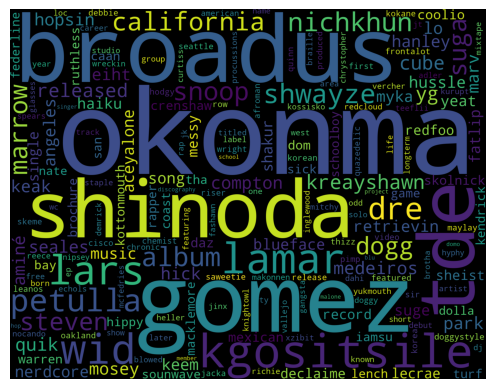

In [ ]:
west_wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(west_str)

plt.imshow(west_wordcloud)
plt.axis('off')
plt.savefig('west_cloud.png', dpi=300)
plt.show()

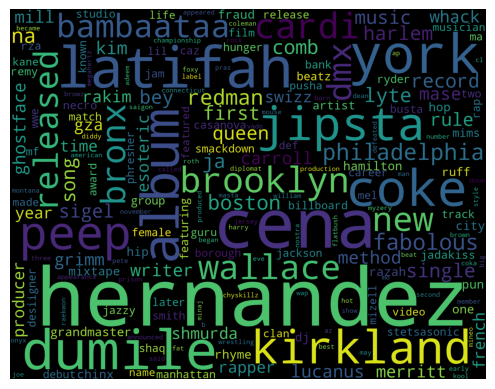

In [ ]:
east_wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(east_str)

plt.imshow(east_wordcloud)
plt.axis('off')
plt.savefig('east_cloud.png', dpi=300)
plt.show()

# Part 3: Communities

Find communities and their modularity (from lecture 7).

Here's what you need to do:
> * In your own words, explain what the measure "modularity" is, and the intuition behind the formula you use to compute it. 
> * Find communities in the network, and explain how you chose to identify the communities: Which algorithm did you use and how does it work?
> * Comment on your results:
>   * How many communities did you find in total?
>   * Compute the value of modularity with the partition created by the algorithm.
>   * Plot and/or print the distribution of community sizes (whichever makes most sense). Comment on your result.
> * Now, partition your rappers into two communities based on which coast they represent.
>   * What is the modularity of this partition? Comment on the result.

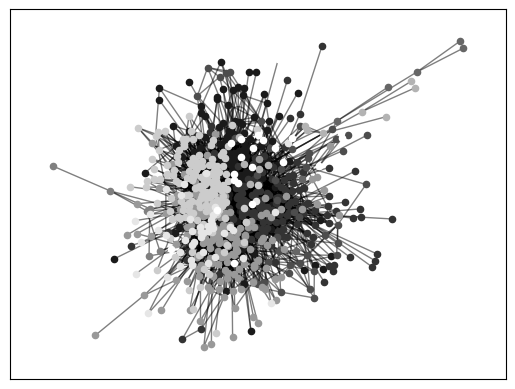

In [ ]:
partition = community.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G,pos, alpha=0.5)
plt.show()

In [ ]:
L_west = G_west.number_of_edges()
L_east = G_east.number_of_edges()
L = G.number_of_edges()
M_west = L_west/L
M_east = L_east/L
M = M_west + M_east
print(M_west, M_east, M)

0.2727272727272727 0.5031382871026524 0.7758655598299251


# Part 4: Sentiment of communities

Analyze the sentiment of communities (lecture 8). More tips & tricks can be found, if you take a look at Lecture 8's exercises.

A couple of additional instructions you will need below:
* Average the average sentiment of the nodes in each community to find a community-level sentiment.

Here's what you need to do (use the LabMT wordlist approach):
> * Calculate and store sentiment for every rapper
> * Create a histogram of all rappers' associated sentiments.
> * What are the 10 rappers with happiest and saddest pages?

Now, compute the sentiment of each coast: 
> * Which is the happiest and which is saddest coast according to the LabMT wordlist approach? (Take the coast's sentiment to be the average sentiment of the coast's rappers' pages (disregarding any rappers with sentiment 0).
> * Use the "label shuffling test" (Week 5 and 8) to test if the coast with the highest wikipedia page sentiment has a page sentiment that is significantly higher (5% confidence bound) than a randomly selected group of rappers of the same size.
> * Does the result make sense to you? Elaborate.

**Congratulations for making it to the end of the Assignment. Good luck with your independent project**

